In [23]:
import numpy as np
import cv2
import albumentations as A
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use("custom_dark")


2023-09-04 12:59:52.766983: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 12:59:53.495373: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lpradier/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-09-04 12:59:53.495420: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lpradier/.local/lib/python3.10/site-packages/cv2/../../l

ESSAI IMG, AUG and PLOT


In [9]:
image = cv2.imread(
    "data/raw/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/zurich/zurich_000000_000019_leftImg8bit.png"
)
image


array([[[ 25,  31,  21],
        [ 22,  29,  18],
        [ 22,  28,  17],
        ...,
        [255, 255, 247],
        [255, 255, 248],
        [255, 255, 247]],

       [[ 25,  32,  22],
        [ 26,  33,  22],
        [ 25,  31,  19],
        ...,
        [255, 255, 245],
        [255, 255, 246],
        [255, 255, 246]],

       [[ 24,  33,  23],
        [ 27,  35,  25],
        [ 27,  36,  24],
        ...,
        [255, 255, 247],
        [255, 255, 248],
        [255, 255, 246]],

       ...,

       [[ 54,  79,  66],
        [ 53,  77,  63],
        [ 59,  81,  65],
        ...,
        [ 63,  69,  52],
        [ 65,  70,  54],
        [ 64,  69,  53]],

       [[ 54,  79,  66],
        [ 53,  77,  63],
        [ 59,  81,  65],
        ...,
        [ 61,  67,  52],
        [ 61,  66,  52],
        [ 61,  66,  52]],

       [[ 54,  79,  66],
        [ 53,  77,  63],
        [ 59,  82,  65],
        ...,
        [ 58,  63,  49],
        [ 58,  62,  49],
        [ 57,  62,  49]]

In [10]:
light = A.Compose(
    [
        A.HorizontalFlip(p=1),
        A.RandomSizedCrop((800 - 100, 800 + 100), 600, 600),
        A.GaussNoise(var_limit=(100, 150), p=1),
    ]
)


In [15]:
x = light(image=image)

Text(0.5, 1.0, 'Aug_Img')

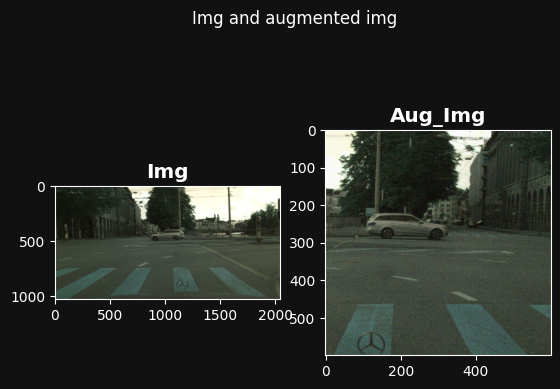

In [25]:
fig, ax = plt.subplots(1, 2)
fig.suptitle("Img and augmented img")
ax[0].imshow(image / 255)
ax[1].imshow(x["image"] / 255)
ax[0].set_title("Img")
ax[1].set_title("Aug_Img")

TEST METHOD AUG IMG


Pas de crop > changement de forme de img
pas forcément suggéré ici
Ici suggère : rotation, cgt echelle, bruit


In [31]:
medium = A.Compose(
    [A.HorizontalFlip(p=1), A.ShiftScaleRotate(p=1), A.MotionBlur(blur_limit=17, p=1)]
)

strong = A.Compose(
    [
        A.HorizontalFlip(p=1),
        A.RGBShift(p=1),
        A.ShiftScaleRotate(p=1),
        A.Blur(blur_limit=11, p=1),
        A.RandomBrightness(p=1),
        A.CLAHE(p=1),
    ]
)

/home/lpradier/.local/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Text(0.5, 1.0, 'Aug_Img')

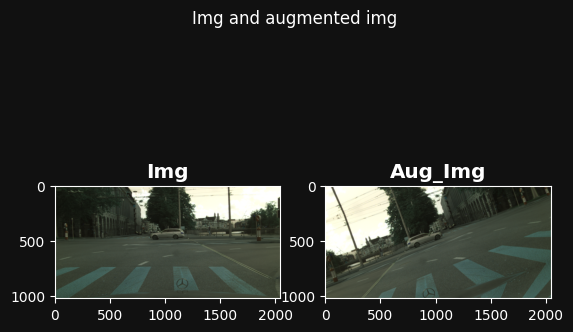

In [32]:
x = medium(image=image)
fig, ax = plt.subplots(1, 2)
fig.suptitle("Img and augmented img")
ax[0].imshow(image / 255)
ax[1].imshow(x["image"] / 255)
ax[0].set_title("Img")
ax[1].set_title("Aug_Img")


Text(0.5, 1.0, 'Aug_Img')

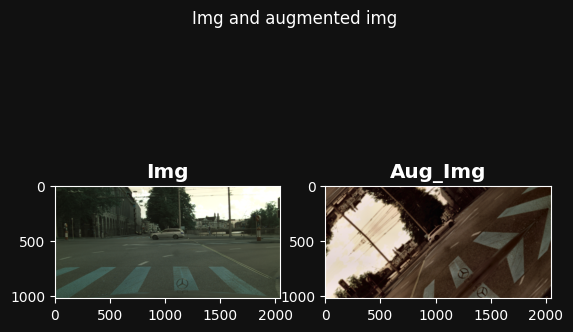

In [33]:
x = strong(image=image)
fig, ax = plt.subplots(1, 2)
fig.suptitle("Img and augmented img")
ax[0].imshow(image / 255)
ax[1].imshow(x["image"] / 255)
ax[0].set_title("Img")
ax[1].set_title("Aug_Img")

FCT FILTRAGE


**HEURISTIQUE HOLDOUT**


In [12]:
from itertools import combinations, chain
import os
import random
import shutil


def holdout(image_dir, mask_dir):
    random.seed(42)
    #!1.Comptage des éléments
    city_list = os.listdir(image_dir)
    city_count = []
    for i in city_list:
        temp = len(os.listdir(os.path.join(image_dir, i)))
        city_count.append(temp)
    # FOR TEST ~ 1/6 TRAIN beg
    min_thr = 1 / 10 * sum(city_count)
    max_thr = 1 / 6 * sum(city_count)
    #!2.Sélection des combinaisons de villes qui respectent diverses cdt
    # Build dict
    citytocount = {key: value for key, value in zip(city_list, city_count)}
    result = []
    # Parse combinations with more than 2 cities
    # 3 cities in VALID
    allCombinations = chain(
        *(combinations(city_list, i) for i in range(3, len(city_list) + 1))
    )
    for c in allCombinations:
        # Get count for this combination
        countForThisCombination = sum((citytocount[name] for name in c))
        # Test for min/max
        if countForThisCombination > min_thr and countForThisCombination < max_thr:
            result += [c]
    #!3. Sélection aléatoire de combinaisons parmis les précédentes
    city_test = random.choice(result)
    #!4. Create new test directory
    os.mkdir(image_dir + "/new_test/")
    os.mkdir(mask_dir + "/new_test/")
    #!5. redirect selected train files to test file
    for ville in city_test:
        for dir in [image_dir, mask_dir]:
            source = dir + "/train/" + str(ville)
            destination = dir + "/new_test/" + str(ville)
            shutil.move(source, destination)
    return city_test

In [13]:
image_dir = "data/raw/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit"
mask_dir = "data/raw/P8_Cityscapes_gtFine_trainvaltest/gtFine"

holdout(image_dir, mask_dir)

('tubingen', 'zurich', 'erfurt', 'jena')

**ESSAI CHARGEMENT MASK**


In [46]:
import cv2
# pas besoin de passer la conversion du filtre en gris pour la représentation et le bornage, juste lui passer bien un masque gris de base
img = cv2.imread(
    "data/raw/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png",
    cv2.IMREAD_COLOR,
)

In [48]:
dist = [np.min(img), np.max(img)]
dist


[0, 33]

Valeur de luminance cohérente avec les définitions des labels qui nous intéressent : _cats_ (bornées à 33)


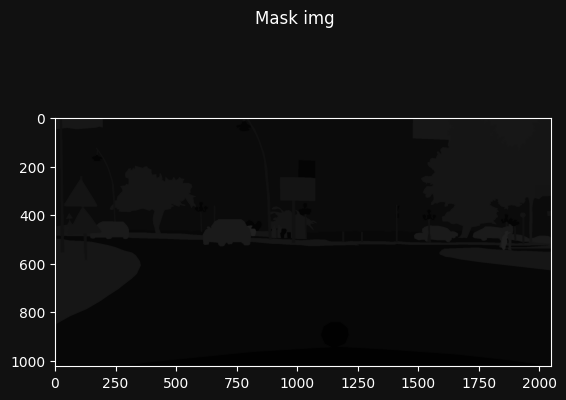

In [47]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Mask img")
ax.imshow(img)